# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Breed Classifier

---

### Introduction

In this notebook, I make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, this code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  The imperfect solution here will nonetheless create a fun user experience!

### The Road Ahead

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write Own Algorithm
* [Step 7](#step7): Test Own Algorithm

---

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

Dog dataset https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames']) #the name of the file in string
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133) # one-hot encoding of the label
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
train_files

array(['dogImages/train\\095.Kuvasz\\Kuvasz_06442.jpg',
       'dogImages/train\\057.Dalmatian\\Dalmatian_04054.jpg',
       'dogImages/train\\088.Irish_water_spaniel\\Irish_water_spaniel_06014.jpg',
       ..., 'dogImages/train\\029.Border_collie\\Border_collie_02069.jpg',
       'dogImages/train\\046.Cavalier_king_charles_spaniel\\Cavalier_king_charles_spaniel_03261.jpg',
       'dogImages/train\\048.Chihuahua\\Chihuahua_03416.jpg'],
      dtype='<U99')

In [4]:
train_targets

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

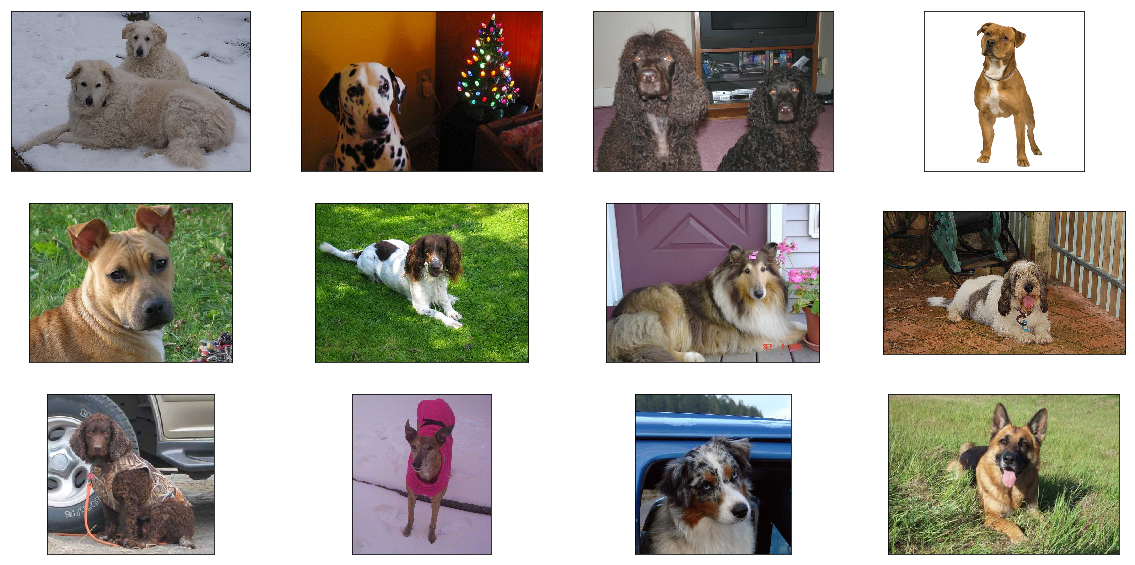

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path) # show images in color
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.
Human dataset https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [6]:
human_files[3]

'lfw\\Laurence_Fishburne\\Laurence_Fishburne_0001.jpg'

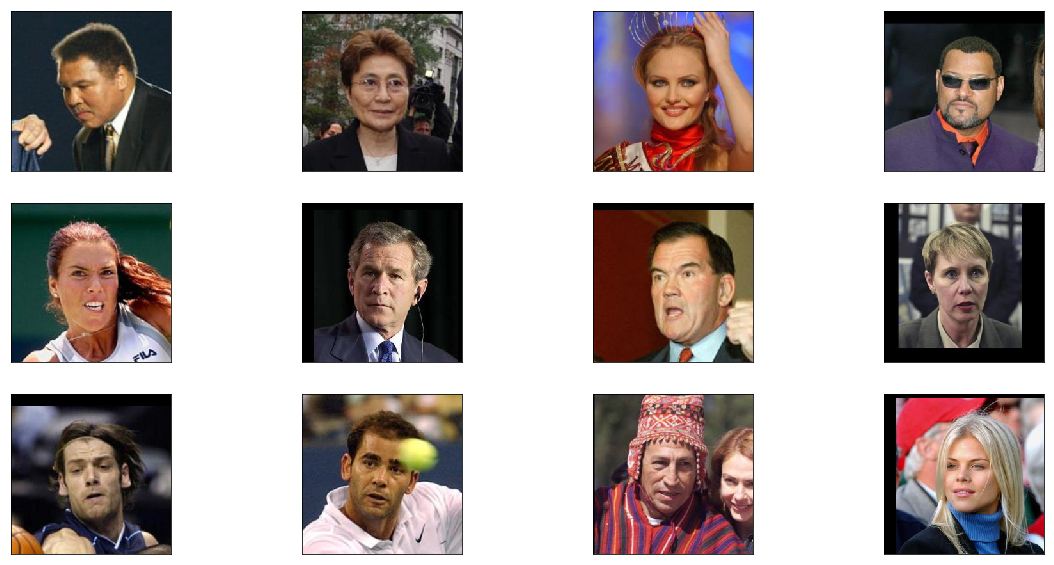

In [7]:
fig = plt.figure(figsize=(20, 10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(human_files[i], ax)

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 0
Number of eyes detected: 0


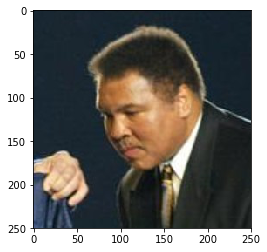

Number of faces detected: 1
Number of eyes detected: 2


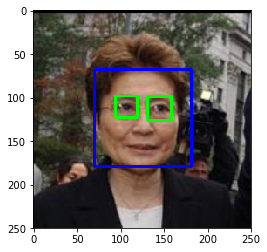

Number of faces detected: 1
Number of eyes detected: 2


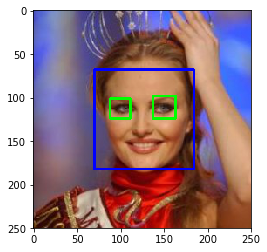

Number of faces detected: 1
Number of eyes detected: 0


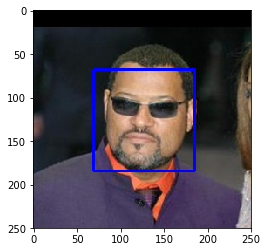

Number of faces detected: 1
Number of eyes detected: 2


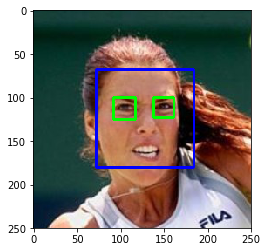

Number of faces detected: 1
Number of eyes detected: 1


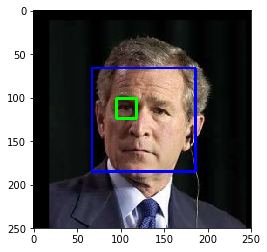

Number of faces detected: 1
Number of eyes detected: 2


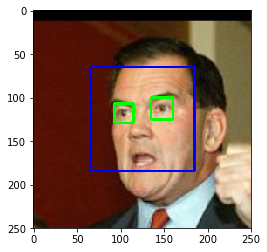

Number of faces detected: 1
Number of eyes detected: 2


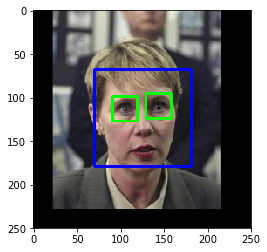

Number of faces detected: 1
Number of eyes detected: 1


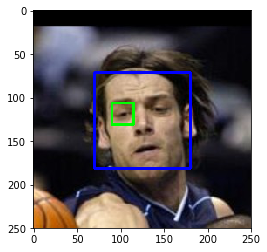

Number of faces detected: 1
Number of eyes detected: 2


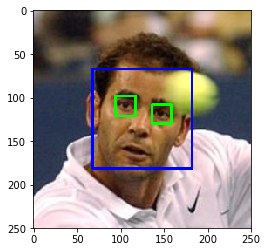

Number of faces detected: 1
Number of eyes detected: 0


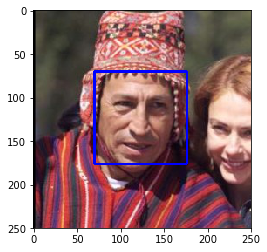

Number of faces detected: 1
Number of eyes detected: 2


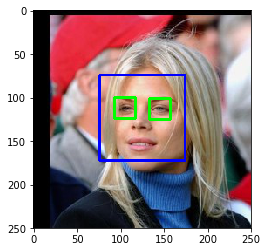

In [8]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye_tree_eyeglasses.xml')

for i in range(12):
    # load color (BGR) image
    img = cv2.imread(human_files[i])
    # convert BGR image to grayscale
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # find eyes in image
    eyes = eye_cascade.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # print number of eye detected in the image
    print('Number of eyes detected:', len(eyes))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # show eyes
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

In [9]:
print (faces)

[[76 74 98 98]]


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [10]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- Percentage of the first 100 images in `human_files` have a detected human face: 99%
- Percentage of the first 100 images in `dog_files` have a detected human face: 11%
- As we can see from the failure detection, if the human does not show front face, it is difficult to detect human in human images. For dogs detected as human, some have both human and dog in the images, and some dogs may be mistaken as human face.

-----------Fail to detect human face in human-----------


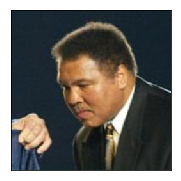

-----------Detect human face in dog-----------


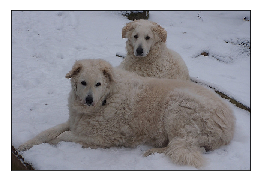

-----------Detect human face in dog-----------


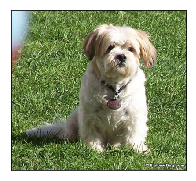

-----------Detect human face in dog-----------


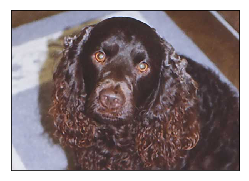

-----------Detect human face in dog-----------


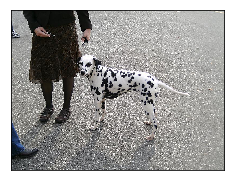

-----------Detect human face in dog-----------


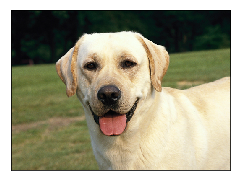

-----------Detect human face in dog-----------


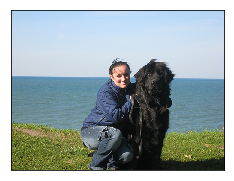

-----------Detect human face in dog-----------


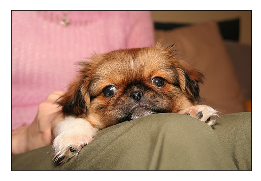

-----------Detect human face in dog-----------


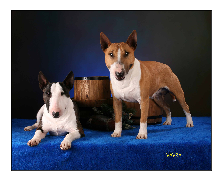

-----------Detect human face in dog-----------


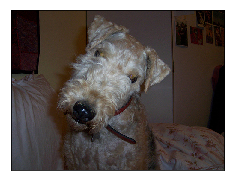

-----------Detect human face in dog-----------


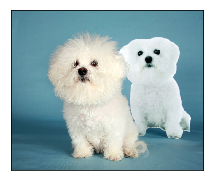

-----------Detect human face in dog-----------


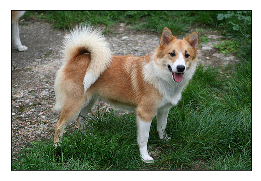

Percentage of the first 100 images in human_files have a detected human face: 99.00%
Percentage of the first 100 images in dog_files have a detected human face: 11.00%


In [12]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def face_detector_performance(files):   
    true_count = 0
    for file in files:
        if face_detector(file): 
            if file.startswith('dogImages'): 
                print ("-----------Detect human face in dog-----------")
                fig = plt.figure(figsize=(20, 10))
                ax = fig.add_subplot(3, 4, 1, xticks=[], yticks=[])
                visualize_img(file, ax)
                plt.show()
            true_count += 1
        else:
            if file.startswith('lfw'): 
                print ("-----------Fail to detect human face in human-----------")
                fig = plt.figure(figsize=(20, 10))
                ax = fig.add_subplot(3, 4, 1, xticks=[], yticks=[])
                visualize_img(file, ax)
                plt.show()
    return 1.*true_count/len(files)

human_perf = face_detector_performance(human_files_short)
dog_perf = face_detector_performance(dog_files_short)

print ("Percentage of the first 100 images in human_files have a detected human face: {0:.2f}%".format(100*human_perf))
print ("Percentage of the first 100 images in dog_files have a detected human face: {0:.2f}%".format(100*dog_perf))

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__
I think users may get frustrated if we set the standard of face images too strict. This is not quite a reasonable expectation to pose on the user. Therefore, we can train our own dataset on human faces using ImageNet dataset and transfer learning. 

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [39]:
ResNet50_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256                                          
___________________________________________________________________________________________

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm 
# Fast, Extensible Progress Meter

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type PIL,Python Imaging Library
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), I notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- Percentage of the first 100 images in `human_files` have a detected dog face: 1%
- Percentage of the first 100 images in `dog_files` have a detected dog face: 100%
- Dog detector performs quite well in detecting dog face in dogs; it has 1% false positive in detecting dog face in human. In this image, as we can see, the human has white hair. 

-----------Detect dog face in human-----------


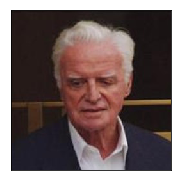

Percentage of the first 100 images in human_files have a detected dog face: 1.00%
Percentage of the first 100 images in dog_files have a detected dog face: 100.00%


In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_detector_performance(files):   
    true_count = 0
    for file in files:
        if dog_detector(file): 
            if file.startswith('lfw'): 
                print ("-----------Detect dog face in human-----------")
                fig = plt.figure(figsize=(20, 10))
                ax = fig.add_subplot(3, 4, 1, xticks=[], yticks=[])
                visualize_img(file, ax)
                plt.show()
            true_count += 1
        else:
            if file.startswith('dogImages'): 
                print ("-----------Fail to detect dog face in dog-----------")
                fig = plt.figure(figsize=(20, 10))
                ax = fig.add_subplot(3, 4, 1, xticks=[], yticks=[])
                visualize_img(file, ax)
                plt.show()
    return 1.*true_count/len(files)

human_perf = dog_detector_performance(human_files_short)
dog_perf = dog_detector_performance(dog_files_short)

print ("Percentage of the first 100 images in human_files have a detected dog face: {0:.2f}%".format(100*human_perf))
print ("Percentage of the first 100 images in dog_files have a detected dog face: {0:.2f}%".format(100*dog_perf))

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I will create a CNN that classifies dog breeds.  I create my CNN _from scratch_, and attain a test accuracy of at least 1%.  In Step 5 of this notebook, I will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  Keras provides a handy estimate of the time that each epoch is likely to take.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  My vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 836/836 [00:10<00:00, 106.20it/s]


In [19]:
# print shape of training set
print('train_tensors:', train_tensors.shape)

# print number of training, validation, and test images
print(train_tensors.shape[0], 'train samples')
print(test_tensors.shape[0], 'test samples')
print(valid_tensors.shape[0], 'validation samples')

train_tensors: (6680, 224, 224, 3)
6680 train samples
836 test samples
835 validation samples


### Model Architecture

Create a CNN to classify dog breed.  At the end of the code cell block, summarize the layers of the model by executing the line:
    
        model.summary()
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I first add a convolutional layer with 16 filters of filter size of 3, to take in the input of file image size 224, 224, 3. And then I reduce the dimension of layers using pooling layer with size of 2. I then add another 2 convolutional layers with pooling layers to capture different features of the image. Then using Dropout, I am able to randomly remove the nodes during training. In the end, I flatten the matrix into vector and add 2 fully connected layers to train more specific features, and output 133 nodes for the 133 breeds. Using activation "softmax", I can get the probability of each breed. This architecture works fine with accuracy of 7.7751%, which is much better than random guessing 1/133. 

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

In [ ]:
from keras.callbacks import ModelCheckpoint  
import time
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.
t0 = time.time()
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=2)

t = time.time()-t0
print ("run time: ",t)

### Load the Model with the Best Validation Loss

In [61]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Ensure that the test accuracy is greater than 1%.

In [62]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.7751%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

In the following step, I will get a chance to use transfer learning to train my own CNN.

### Obtain Bottleneck Features

In [63]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [64]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [65]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [66]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 11.83468, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 12.8192 - acc: 0.1099 - val_loss: 11.8347 - val_acc: 0.1713
Epoch 2/20
Epoch 00001: val_loss improved from 11.83468 to 11.14461, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 11.1448 - acc: 0.2287 - val_loss: 11.1446 - val_acc: 0.2335
Epoch 3/20
Epoch 00002: val_loss improved from 11.14461 to 10.85407, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.5383 - acc: 0.2909 - val_loss: 10.8541 - val_acc: 0.2431
Epoch 4/20
Epoch 00003: val_loss improved from 10.85407 to 10.53045, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.2174 - acc: 0.3202 - val_loss: 10.5305 - val_acc: 0.2874
Epoch 5/20
Epoch 00004: val_loss improved from 10.53045 to 10.39597, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 10.0633 - acc: 0.3455 - val_loss: 10.3960 - val_acc: 

### Load the Model with the Best Validation Loss

In [67]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [68]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 36.2440%


### Predict Dog Breed with the Model

In [70]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model, with the highest probability
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I will now use transfer learning to create a CNN that can identify dog breed from images.  The CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I use the bottleneck features from a different pre-trained model.  Use these pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [61]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  At the end of the code cell block, summarize the layers of the model by executing the line:
    
        <model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
From the bottleneck input, I add a globalaveragepoolinglayer to reduce the dimension of the input data. Then I add a fully connected dense layer in the end with 133 output nodes and "softmax" to generate the probability of each breed. This transfer learning works because the training label is very similar to the ImageNet data (exactly the same) and the training size of the data is relatively small. To avoid overfitting, we can keep the weights of all hidden layers unchanged and only train the fully connected output layer.  

In [62]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [63]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

In [64]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.81883, saving model to saved_models/weights.best.Resnet50.hdf5
6s - loss: 1.6453 - acc: 0.5942 - val_loss: 0.8188 - val_acc: 0.7521
Epoch 2/20
Epoch 00001: val_loss improved from 0.81883 to 0.73216, saving model to saved_models/weights.best.Resnet50.hdf5
2s - loss: 0.4463 - acc: 0.8572 - val_loss: 0.7322 - val_acc: 0.7749
Epoch 3/20
Epoch 00002: val_loss improved from 0.73216 to 0.67093, saving model to saved_models/weights.best.Resnet50.hdf5
2s - loss: 0.2674 - acc: 0.9120 - val_loss: 0.6709 - val_acc: 0.7964
Epoch 4/20
Epoch 00003: val_loss improved from 0.67093 to 0.62920, saving model to saved_models/weights.best.Resnet50.hdf5
2s - loss: 0.1761 - acc: 0.9455 - val_loss: 0.6292 - val_acc: 0.8108
Epoch 5/20
Epoch 00004: val_loss did not improve
2s - loss: 0.1222 - acc: 0.9612 - val_loss: 0.6693 - val_acc: 0.8228
Epoch 6/20
Epoch 00005: val_loss did not improve
2s - loss: 0.0901 - ac

### Load the Model with the Best Validation Loss

In [65]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Ensure that the test accuracy is greater than 60%.

In [66]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.9043%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by the model.  

Similar to the analogous function in Step 5, the function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to my chosen CNN architecture, I need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [67]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model, with the highest probability
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write Own Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write  Own Algorithm

In [31]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def detect(img_path):
    if dog_detector(img_path): # dog is detected
        pred = Resnet50_predict_breed(img_path)
        print ("Hello, dog!")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print ("You are a ...\n", pred)
    elif face_detector(img_path): #human detected
        pred = Resnet50_predict_breed(img_path)
        print ("Hello, human!")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        print ("You look like a ...\n", pred)
    else: # not human or dog
        print ("Error: neither dog nor human is detected.")   
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

---
<a id='step7'></a>
## Step 7: Test Own Algorithm

What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test My Own Algorithm on Sample Images!

Test the algorithm at least six images.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The algorithm predicts me being a Lowchen, very friendly and intelligent dog. 
The output is better than I expected. It can well distinguish human, dog, and other images. It can also tell cats from dogs. However, it cannot detect mutt, a mixture of different breed. To further improve the algorithm, I can do the following
1. if a dog appears at least 40% of two breeds, return "mutt" instead of the highest possible breed
2. use data augmentation to generate more training data via random transformation
3. try different transfer learning model and dense network architecture

In [104]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

Hello, dog!


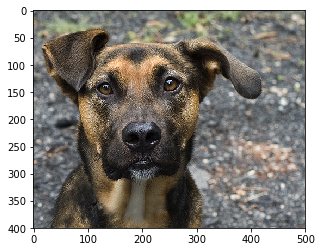

You are a ...
 Anatolian_shepherd_dog


In [110]:
detect('mytest/mutt.jpg')

Hello, dog!


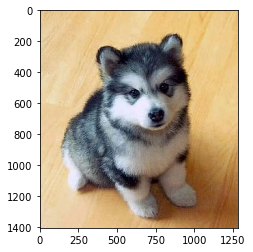

You are a ...
 Alaskan_malamute


In [84]:
detect('mytest/pomsky_8.jpg')

Hello, dog!


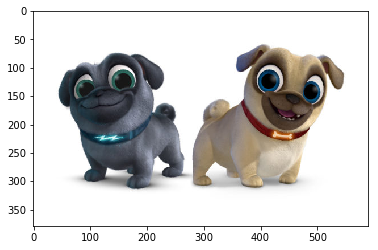

You are a ...
 Basset_hound


In [85]:
detect('mytest/disney.jpg')

Error: neither dog nor human is detected.


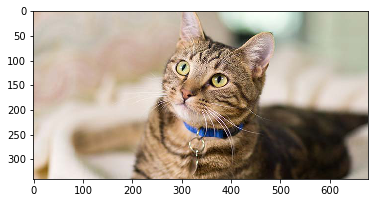

In [79]:
detect('mytest/HP_PCC_md_0130_cat53.jpg')

Error: neither dog nor human is detected.


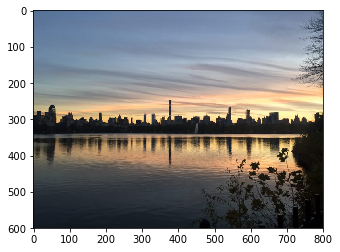

In [114]:
detect('mytest/IMG_2208.jpg')

Hello, human!


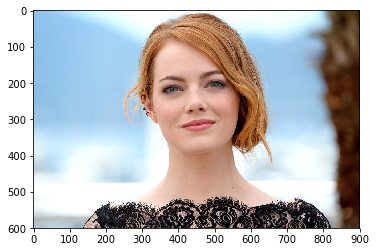

You look like a ...
 Maltese


In [81]:
detect('mytest/emma-stone-aloha-miscast.jpg')

Hello, human!


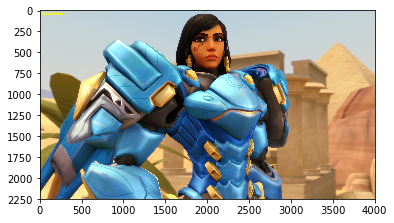

You look like a ...
 German_pinscher


In [83]:
detect('mytest/pharah.jpg')